## Task 1. N-gram models

Create different pipelines for extracting features from texts using 1-gram, 2-gram and 3-gram symbol counting model. Test your pipeline by extracting features from a subset of the 20 newsgroup dataset (https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Evaluate performance of your pipelines. How arity of the the gram model affects performance?

In [111]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [112]:
categories = ['alt.atheism', 'sci.space', 'comp.graphics', 'rec.sport.baseball']
newsgroups = fetch_20newsgroups(
    subset='all', 
    categories=categories, 
    remove=('headers', 'footers', 'quotes')
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {len(newsgroups.target_names)}")

Training samples: 2627
Test samples: 1126
Number of classes: 4


In [113]:
def create_ngram_pipeline(n):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), max_features=5000)
    classifier = LogisticRegression(max_iter=1000)
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])
    
    return pipeline

In [114]:
pipelines = {
    '1-gram': create_ngram_pipeline(1),
    '2-gram': create_ngram_pipeline(2),
    '3-gram': create_ngram_pipeline(3)
}

In [115]:
results = {}

for name, pipeline in pipelines.items():
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, target_names=newsgroups.target_names, output_dict=True)
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")


Training 1-gram model...
1-gram Accuracy: 0.6270

Training 2-gram model...
2-gram Accuracy: 0.7700

Training 3-gram model...
3-gram Accuracy: 0.8028


In [116]:
print("Performance Comparison:")
for name, result in results.items():
    print(f"{name} Model:")
    print(f"\tAccuracy: {result['accuracy']:.4f}")
    print("\tPer-class F1-scores:")
    for class_name, metrics in result['classification_report'].items():
        if isinstance(metrics, dict):
            print(f"\t\t{class_name}: {metrics['f1-score']:.4f}")

Performance Comparison:
1-gram Model:
	Accuracy: 0.6270
	Per-class F1-scores:
		alt.atheism: 0.6099
		comp.graphics: 0.6678
		rec.sport.baseball: 0.6936
		sci.space: 0.5130
		macro avg: 0.6211
		weighted avg: 0.6217
2-gram Model:
	Accuracy: 0.7700
	Per-class F1-scores:
		alt.atheism: 0.7485
		comp.graphics: 0.8193
		rec.sport.baseball: 0.8056
		sci.space: 0.6989
		macro avg: 0.7681
		weighted avg: 0.7686
3-gram Model:
	Accuracy: 0.8028
	Per-class F1-scores:
		alt.atheism: 0.8041
		comp.graphics: 0.8427
		rec.sport.baseball: 0.8305
		sci.space: 0.7320
		macro avg: 0.8023
		weighted avg: 0.8021


#### Analysis:
Observation:
- **1-gram:** Captures very basic symbol frequency, low contextual information.
- **2-gram:** aptures pairs of characters, introduces some context, improving performance.
- **3-gram:** Captures more contextual information but may introduce noise or sparsity if data is limited.

Performance trends:
- Highest accuracy: 3-gram with 0.8028
- Higher n-grams may improve performance by capturing more context, but can suffer from sparsity and increased computational cost.
- Lower n-grams are simpler and faster but may underfit if context is critical.

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", context="talk")

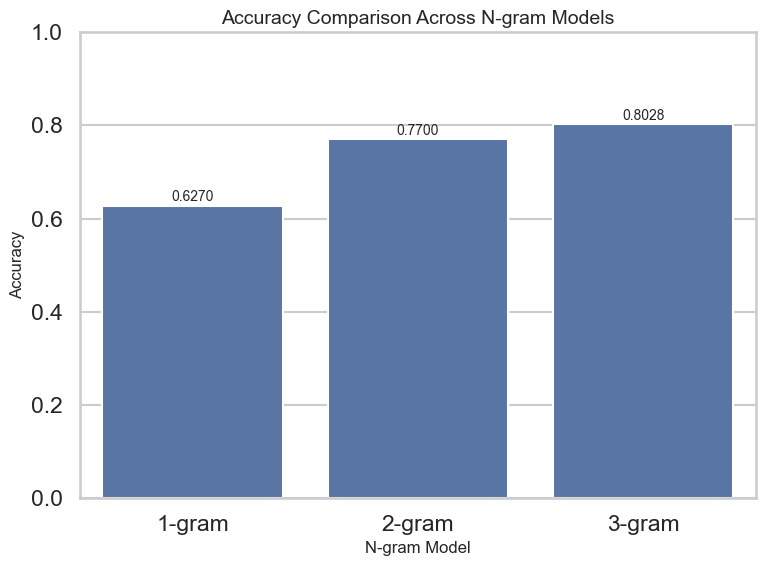

In [118]:
accuracies = {name: result['accuracy'] for name, result in results.items()}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Accuracy Comparison Across N-gram Models', fontsize=14)
plt.xlabel('N-gram Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

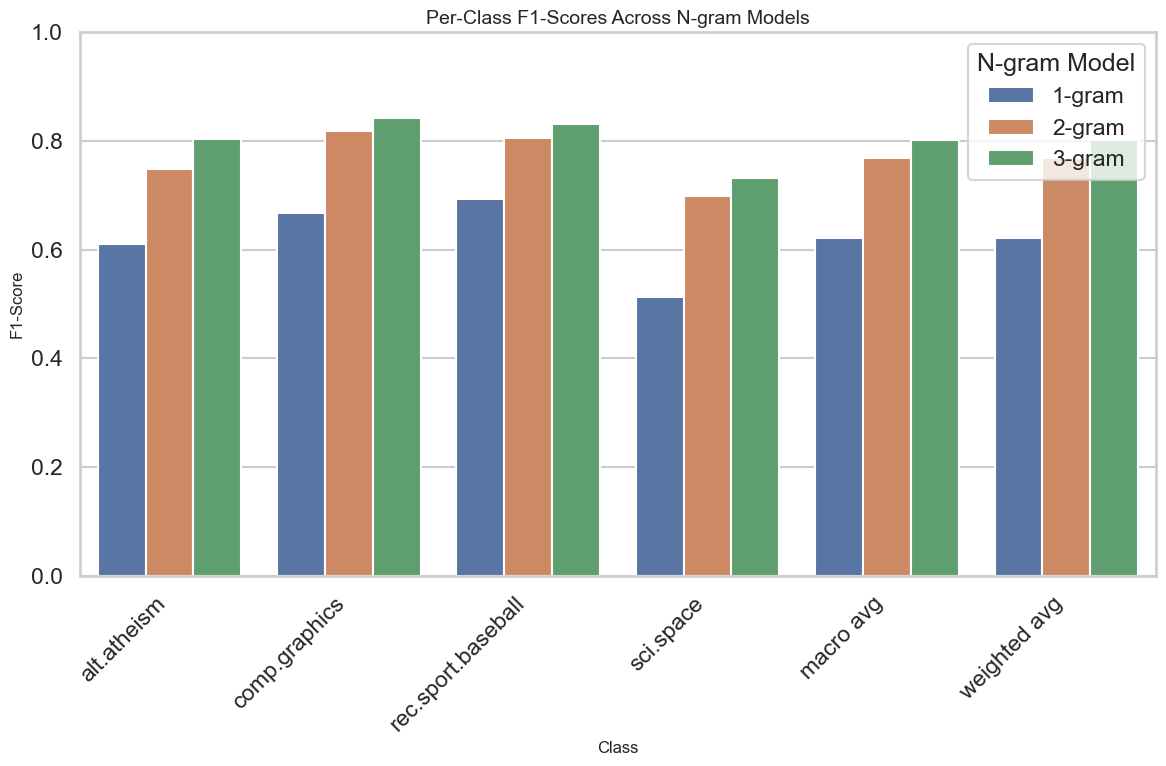

In [119]:
f1_data = []
for name, result in results.items():
    for class_name, metrics in result['classification_report'].items():
        if isinstance(metrics, dict):
            f1_data.append({
                'Model': name,
                'Class': class_name,
                'F1-score': metrics['f1-score']
            })

f1_df = pd.DataFrame(f1_data)

plt.figure(figsize=(12, 8))
sns.barplot(x='Class', y='F1-score', hue='Model', data=f1_df)
plt.title('Per-Class F1-Scores Across N-gram Models', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='N-gram Model')
plt.tight_layout()
plt.show()

## Task 2. Custom transformers
Create your custom transformer, which filters all N-grams from the text, which has the the highest frequency.

In [120]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [121]:
categories = ['alt.atheism', 'sci.space', 'comp.graphics', 'rec.sport.baseball']
newsgroups = fetch_20newsgroups(
    subset='all', 
    categories=categories, 
    remove=('headers', 'footers', 'quotes')
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {len(newsgroups.target_names)}")

Training samples: 2627
Test samples: 1126
Number of classes: 4


In [122]:
class HighFreqNGramFilter(BaseEstimator, TransformerMixin):
    def __init__(self, ngram_range=(1, 1), max_features=5000, top_n_remove=10):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.top_n_remove = top_n_remove
        self.vectorizer = None
        self.high_freq_ngrams = None
    
    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(
            analyzer='char',
            ngram_range=self.ngram_range,
            max_features=self.max_features
        )
        X_counts = self.vectorizer.fit_transform(X)
        
        ngram_sums = np.array(X_counts.sum(axis=0)).flatten()
        top_n_indices = np.argsort(ngram_sums)[-self.top_n_remove:]
        
        feature_names = self.vectorizer.get_feature_names_out()
        self.high_freq_ngrams = [feature_names[i] for i in top_n_indices]
        
        return self
    
    def transform(self, X):
        X_transformed = self.vectorizer.transform(X)
        feature_names = self.vectorizer.get_feature_names_out()
        
        high_freq_indices = [i for i, name in enumerate(feature_names) if name in self.high_freq_ngrams]
        
        X_transformed = X_transformed.toarray()
        X_transformed[:, high_freq_indices] = 0
        
        return X_transformed

In [123]:
def create_filtered_ngram_pipeline(n):
    pipeline = Pipeline([
        ('ngram_filter', HighFreqNGramFilter(ngram_range=(n, n), max_features=5000, top_n_remove=30)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    return pipeline


pipelines = {
    '1-gram_filtered': create_filtered_ngram_pipeline(1),
    '2-gram_filtered': create_filtered_ngram_pipeline(2),
    '3-gram_filtered': create_filtered_ngram_pipeline(3)
}

results = {}
for name, pipeline in pipelines.items():
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, target_names=newsgroups.target_names, output_dict=True)
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")


Training 1-gram_filtered model...
1-gram_filtered Accuracy: 0.4538

Training 2-gram_filtered model...
2-gram_filtered Accuracy: 0.7709

Training 3-gram_filtered model...
3-gram_filtered Accuracy: 0.8171


In [124]:
print("Performance Comparison:")
for name, result in results.items():
    print(f"{name} Model:")
    print(f"\tAccuracy: {result['accuracy']:.4f}")
    print("\tPer-class F1-scores:")
    for class_name, metrics in result['classification_report'].items():
        if isinstance(metrics, dict):
            print(f"\t\t{class_name}: {metrics['f1-score']:.4f}")

Performance Comparison:
1-gram_filtered Model:
	Accuracy: 0.4538
	Per-class F1-scores:
		alt.atheism: 0.5069
		comp.graphics: 0.4906
		rec.sport.baseball: 0.4943
		sci.space: 0.2805
		macro avg: 0.4431
		weighted avg: 0.4408
2-gram_filtered Model:
	Accuracy: 0.7709
	Per-class F1-scores:
		alt.atheism: 0.7465
		comp.graphics: 0.8206
		rec.sport.baseball: 0.8050
		sci.space: 0.7036
		macro avg: 0.7689
		weighted avg: 0.7695
3-gram_filtered Model:
	Accuracy: 0.8171
	Per-class F1-scores:
		alt.atheism: 0.8216
		comp.graphics: 0.8634
		rec.sport.baseball: 0.8390
		sci.space: 0.7443
		macro avg: 0.8171
		weighted avg: 0.8166


## Task 3. Extracting features from images
Create a pipeline for extracting features from images. Try to make your pipeline as versitile as possible, so that you can create different feature models. Consider following options:

1. Informativeness of the model (how many information features contain).
2. Complexity of the model (how hard it is to extract features)
3. Preprocessing of features (is it necessary to perform some kind of additional transformation on the extracted features).

In the end you must have a number of configured transformers and feature extractors, which you have assembled in different pipelines.

Test your pipeline with the MNIST Database of hand-written digits: https://archive.ics.uci.edu/dataset/683/mnist+database+of+handwritten+digits or https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits.

Is it possible to somehow evaluate or compare informativeness of the models without solving classification or regression tasks. 

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern, hog
from sklearn.base import BaseEstimator, TransformerMixin

In [133]:
def scale_images(images):
    return images / 16.0


def flatten_images(images):
    return images.reshape(images.shape[0], -1)


class PCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=20):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.reconstructed_images_ = None

    def fit(self, X, y=None):
        self.pca.fit(X)
        return self

    def transform(self, X):
        transformed = self.pca.transform(X)
        self.reconstructed_images_ = self.pca.inverse_transform(transformed).reshape(-1, 8, 8)
        return transformed


class LBPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, P=8, R=1, method='uniform'):
        self.P = P
        self.R = R
        self.method = method
        self.lbp_images_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples = X.shape[0]
        features = []
        self.lbp_images_ = []
        for i in range(n_samples):
            lbp = local_binary_pattern(X[i], P=self.P, R=self.R, method=self.method)
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.P + 3), range=(0, self.P + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            features.append(hist)
            self.lbp_images_.append(lbp)
        self.lbp_images_ = np.array(self.lbp_images_)
        return np.array(features)


class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        self.visualize = visualize
        self.hog_images_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples = X.shape[0]
        features = []
        if self.visualize:
            self.hog_images_ = []
        for i in range(n_samples):
            hog_output = hog(X[i], orientations=self.orientations, pixels_per_cell=self.pixels_per_cell,
                             cells_per_block=self.cells_per_block, block_norm=self.block_norm,
                             visualize=self.visualize, feature_vector=True)
            if self.visualize:
                hog_features, hog_image = hog_output
                self.hog_images_.append(hog_image)
            else:
                hog_features = hog_output
            features.append(hog_features)
        if self.visualize:
            self.hog_images_ = np.array(self.hog_images_)
        return np.array(features)


scale_transformer = FunctionTransformer(scale_images)
flatten_transformer = FunctionTransformer(flatten_images)
pca_transformer = PCATransformer(n_components=20)
lbp_transformer = LBPTransformer(P=8, R=1, method='uniform')
hog_transformer = HOGTransformer(orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

Images shape: (1797, 8, 8)


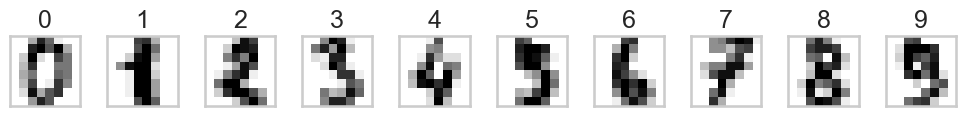

In [134]:
digits = load_digits()
X_images, y = digits.images, digits.target
print("Images shape:", X_images.shape)

digit_indices = []
for digit in range(10):
    idx = np.where(y == digit)[0][0]
    digit_indices.append(idx)

fig, axes = plt.subplots(1, 10, figsize=(10, 2), subplot_kw={'xticks': [], 'yticks': []})
for ax, idx in zip(axes, digit_indices):
    ax.imshow(X_images[idx], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"{y[idx]}")
plt.tight_layout()
plt.show()

In [135]:
X_scaled = scale_transformer.transform(X_images)

X_raw = flatten_transformer.transform(X_scaled)
print(f"Raw Pixels features shape: {X_raw.shape}")

X_flattened = flatten_transformer.transform(X_scaled)
X_pca = pca_transformer.fit_transform(X_flattened)
print(f"PCA features shape: {X_pca.shape}")

X_lbp = lbp_transformer.transform(X_scaled)
print(f"LBP features shape: {X_lbp.shape}")

X_hog = hog_transformer.transform(X_scaled)
print(f"HOG features shape: {X_hog.shape}")

Raw Pixels features shape: (1797, 64)
PCA features shape: (1797, 20)
LBP features shape: (1797, 10)
HOG features shape: (1797, 36)


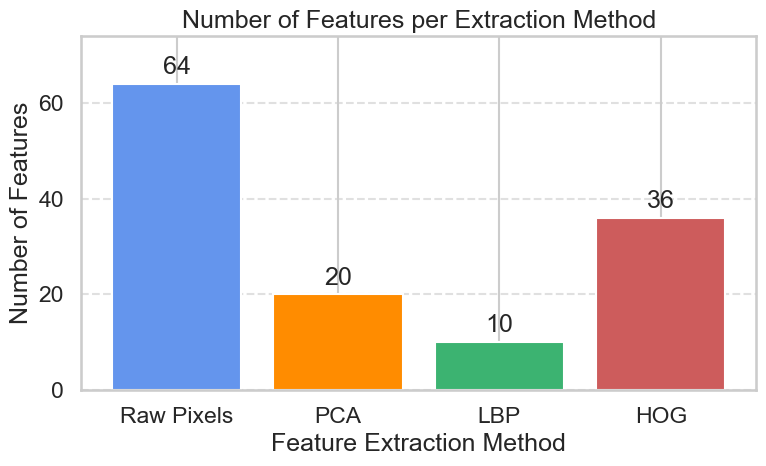

In [141]:
feature_shapes = {
    "Raw Pixels": X_raw.shape[1],
    "PCA": X_pca.shape[1],
    "LBP": X_lbp.shape[1],
    "HOG": X_hog.shape[1],
}

plt.figure(figsize=(8, 5))
bars = plt.bar(feature_shapes.keys(), feature_shapes.values(), color=['cornflowerblue', 'darkorange', 'mediumseagreen', 'indianred'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, yval, ha='center', va='bottom')

plt.title('Number of Features per Extraction Method')
plt.xlabel('Feature Extraction Method')
plt.ylabel('Number of Features')
plt.ylim(0, max(feature_shapes.values()) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

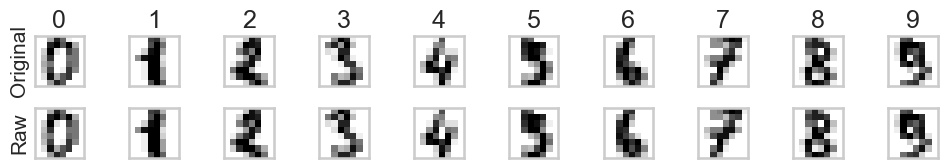

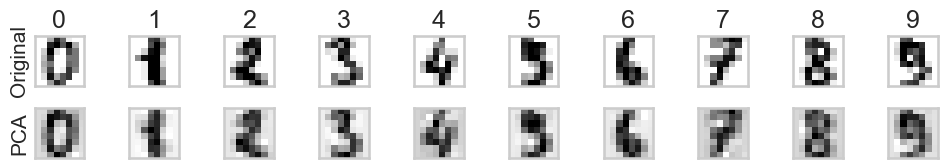

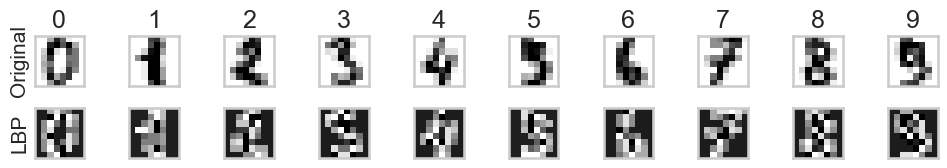

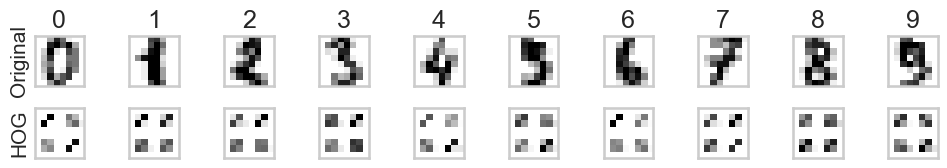

In [142]:
sample_images = X_scaled[digit_indices]

fig, axes = plt.subplots(2, 10, figsize=(10, 2), subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, img) in enumerate(zip(axes[0], sample_images)):
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.set_title(f"{i}")
for i, (ax, img) in enumerate(zip(axes[1], sample_images)):
    ax.imshow(img, cmap=plt.cm.gray_r)
axes[0, 0].set_ylabel("Original", size='small')
axes[1, 0].set_ylabel("Raw", size='small')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 10, figsize=(10, 2), subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, img) in enumerate(zip(axes[0], sample_images)):
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.set_title(f"{i}")
for i, (ax, idx) in enumerate(zip(axes[1], digit_indices)):
    ax.imshow(pca_transformer.reconstructed_images_[idx], cmap=plt.cm.gray_r)
axes[0, 0].set_ylabel("Original", size='small')
axes[1, 0].set_ylabel("PCA", size='small')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 10, figsize=(10, 2), subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, img) in enumerate(zip(axes[0], sample_images)):
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.set_title(f"{i}")
for i, (ax, idx) in enumerate(zip(axes[1], digit_indices)):
    ax.imshow(lbp_transformer.lbp_images_[idx], cmap=plt.cm.gray_r)
axes[0, 0].set_ylabel("Original", size='small')
axes[1, 0].set_ylabel("LBP", size='small')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 10, figsize=(10, 2), subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, img) in enumerate(zip(axes[0], sample_images)):
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.set_title(f"{i}")
for i, (ax, idx) in enumerate(zip(axes[1], digit_indices)):
    ax.imshow(hog_transformer.hog_images_[idx], cmap=plt.cm.gray_r)
axes[0, 0].set_ylabel("Original", size='small')
axes[1, 0].set_ylabel("HOG", size='small')
plt.tight_layout()
plt.show()